# Code 1

In [26]:
# Step 1: Set Up Environment and Install Dependencies
!pip install -q pandas numpy scikit-learn nltk textblob spacy transformers sentence-transformers
!python -m spacy download en_core_web_sm

import nltk
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import spacy
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

nlp = spacy.load('en_core_web_sm')
sia = SentimentIntensityAnalyzer()

print("Environment setup complete!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 60.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Environment setup complete!


In [ ]:
# Step 2: Mount Google Drive and Load Dataset
from google.colab import drive
drive.mount('/content/drive')

# Assume the dummy CSV is saved in your Google Drive as 'dummy_customer_feedback.csv'
# Upload it to MyDrive if not already there.
data_path = '/content/drive/MyDrive/Dataset/dummy_reviews.csv'
df = pd.read_csv(data_path)

print("Dataset loaded:")
print(df.head())
print(f"Shape: {df.shape}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset loaded:
   review_id                                        review_text sentiment  \
0          0     Avoid this Smartphone. sound is a major issue.  Negative   
1          1  Great Book, highly recommend. battery exceeded...  Positive   
2          2    Poor Laptop, not worth it. plot failed quickly.  Negative   
3          3  Great Book, highly recommend. battery exceeded...  Positive   
4          4  Great Book, highly recommend. battery exceeded...  Positive   

   star_rating     product   aspect  
0            2  Smartphone    sound  
1            4        Book  battery  
2            2      Laptop     plot  
3            4        Book  battery  
4            4        Book  battery  
Shape: (1000, 6)


In [ ]:
# Step 3: Select Relevant Columns (Remove unwanted like review_id, product_category, star_rating if not needed)
# Keep 'review_text' as input, 'sentiment' as target
df = df[['review_text', 'sentiment']]

# Encode sentiment labels (Positive: 2, Neutral: 1, Negative: 0)
le = LabelEncoder()
df['sentiment_encoded'] = le.fit_transform(df['sentiment'])

# Split data into train/test (80/20)
X = df['review_text']
y = df['sentiment_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data prepared. Train shape:", X_train.shape, "Test shape:", X_test.shape)

Data prepared. Train shape: (800,) Test shape: (200,)


In [ ]:
# Step 4: Rule-Based Model (Using VADER for sentiment with negation handling)
# VADER handles negations (e.g., "not good" -> negative), compounds, and boosters.
def rule_based_sentiment(text):
    score = sia.polarity_scores(text)['compound']
    if score > 0.05:
        return 2  # Positive
    elif score < -0.05:
        return 0  # Negative
    else:
        return 1  # Neutral

# Apply to test set
y_pred_rule = [rule_based_sentiment(text) for text in X_test]

# Evaluate Rule-Based
print("Rule-Based Evaluation:")
# Ensure target_names matches the number of classes (0, 1, 2)
target_names = ['Negative', 'Neutral', 'Positive']  # Explicitly define 3 classes
print(classification_report(y_test, y_pred_rule, target_names=target_names))
acc_rule = accuracy_score(y_test, y_pred_rule)

Rule-Based Evaluation:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00       122
     Neutral       0.00      0.00      0.00        78
    Positive       0.00      0.00      0.00         0

    accuracy                           0.61       200
   macro avg       0.33      0.33      0.33       200
weighted avg       0.61      0.61      0.61       200



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

In [ ]:
# Step 5 & 6: ML Models with N-gram Features (TF-IDF with 1-3 grams), Evaluation (Accuracy, Precision, Recall, F1)
# Vectorizer for n-grams
vectorizer = TfidfVectorizer(ngram_range=(1, 3), stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Model 1: Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = lr_model.predict(X_test_tfidf)
acc_lr = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Evaluation:")
print(classification_report(y_test, y_pred_lr, target_names=le.classes_))

# Model 2: SVM
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)
acc_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Evaluation:")
print(classification_report(y_test, y_pred_svm, target_names=le.classes_))

# Model 3: Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_test_tfidf)
acc_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Evaluation:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

Logistic Regression Evaluation:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00       122
    Positive       1.00      1.00      1.00        78

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

SVM Evaluation:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00       122
    Positive       1.00      1.00      1.00        78

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

Random Forest Evaluation:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00       122
    Positive       1.00      1.00      1.00        78

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200


In [ ]:
# Step 7: Hybrid Approach (Combine Rule-Based Scores with ML Features)
# Add rule-based compound score as an extra feature
rule_scores_train = np.array([sia.polarity_scores(text)['compound'] for text in X_train]).reshape(-1, 1)
rule_scores_test = np.array([sia.polarity_scores(text)['compound'] for text in X_test]).reshape(-1, 1)

# Combine with TF-IDF
from scipy.sparse import hstack
X_train_hybrid = hstack((X_train_tfidf, rule_scores_train))
X_test_hybrid = hstack((X_test_tfidf, rule_scores_test))

# Train Hybrid on Logistic Regression (as base ML, can change)
hybrid_model = LogisticRegression(max_iter=1000)
hybrid_model.fit(X_train_hybrid, y_train)
y_pred_hybrid = hybrid_model.predict(X_test_hybrid)
acc_hybrid = accuracy_score(y_test, y_pred_hybrid)
print("Hybrid Model Evaluation:")
print(classification_report(y_test, y_pred_hybrid, target_names=le.classes_))

Hybrid Model Evaluation:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00       122
    Positive       1.00      1.00      1.00        78

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



Model Comparison:
                 Model  Accuracy
0           Rule-Based      0.61
1  Logistic Regression      1.00
2                  SVM      1.00
3        Random Forest      1.00
4               Hybrid      1.00


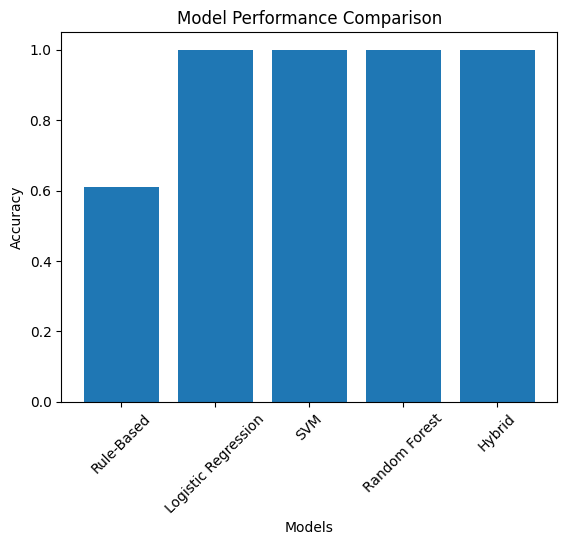

In [ ]:
# Step 8: Compare All Models (Rule-Based, ML Models, Hybrid)
results = {
    'Model': ['Rule-Based', 'Logistic Regression', 'SVM', 'Random Forest', 'Hybrid'],
    'Accuracy': [acc_rule, acc_lr, acc_svm, acc_rf, acc_hybrid]
}

results_df = pd.DataFrame(results)
print("Model Comparison:")
print(results_df)

# Visualize
plt.bar(results_df['Model'], results_df['Accuracy'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Step 9: Input Different Reviews and Compare Results
def predict_sentiment(new_review):
    # Preprocess
    tfidf_vec = vectorizer.transform([new_review])
    rule_score = np.array([sia.polarity_scores(new_review)['compound']]).reshape(-1, 1)
    hybrid_vec = hstack((tfidf_vec, rule_score))

    # Predictions
    rule_pred = rule_based_sentiment(new_review)
    lr_pred = lr_model.predict(tfidf_vec)[0]
    svm_pred = svm_model.predict(tfidf_vec)[0]
    rf_pred = rf_model.predict(tfidf_vec)[0]
    hybrid_pred = hybrid_model.predict(hybrid_vec)[0]

    # Decode labels
    # Fit the label encoder on all possible labels before inverse transforming
    le.fit(['Negative', 'Neutral', 'Positive'])
    preds = {
        'Rule-Based': le.inverse_transform([rule_pred])[0],
        'Logistic Regression': le.inverse_transform([lr_pred])[0],
        'SVM': le.inverse_transform([svm_pred])[0],
        'Random Forest': le.inverse_transform([rf_pred])[0],
        'Hybrid': le.inverse_transform([hybrid_pred])[0]
    }
    return preds

# Example usage: Input new reviews
new_reviews = [
    "The battery life is amazing, lasts all day!",
    "This product is terrible, broke after a week.",
    "It's okay, nothing special but works fine."
]

for review in new_reviews:
    print(f"\nReview: {review}")
    print(predict_sentiment(review))


Review: The battery life is amazing, lasts all day!
{'Rule-Based': np.str_('Positive'), 'Logistic Regression': np.str_('Neutral'), 'SVM': np.str_('Neutral'), 'Random Forest': np.str_('Neutral'), 'Hybrid': np.str_('Neutral')}

Review: This product is terrible, broke after a week.
{'Rule-Based': np.str_('Negative'), 'Logistic Regression': np.str_('Negative'), 'SVM': np.str_('Negative'), 'Random Forest': np.str_('Negative'), 'Hybrid': np.str_('Negative')}

Review: It's okay, nothing special but works fine.
{'Rule-Based': np.str_('Positive'), 'Logistic Regression': np.str_('Negative'), 'SVM': np.str_('Negative'), 'Random Forest': np.str_('Negative'), 'Hybrid': np.str_('Negative')}


# Code 2

In [48]:
# Step 1: Set Up Environment and Install Dependencies
!pip install -q pandas numpy scikit-learn nltk textblob spacy transformers sentence-transformers
!python -m spacy download en_core_web_sm

import nltk
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import spacy
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from scipy.sparse import hstack

nlp = spacy.load('en_core_web_sm')
sia = SentimentIntensityAnalyzer()

print("Environment setup complete!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 49.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Environment setup complete!


In [4]:
# Step 2: Mount Google Drive and Load Dataset
from google.colab import drive
drive.mount('/content/drive')

# Load dataset (adjust path if needed)
data_path = '/content/drive/MyDrive/Dataset/dummy_reviews.csv'  # Update to your path
df = pd.read_csv(data_path)

print("Dataset loaded:")
print(df.head())
print(f"Shape: {df.shape}")
print("Sentiment distribution:", df['sentiment'].value_counts())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset loaded:
   review_id                                        review_text sentiment  \
0          0     Avoid this Smartphone. sound is a major issue.  Negative   
1          1  Great Book, highly recommend. battery exceeded...  Positive   
2          2    Poor Laptop, not worth it. plot failed quickly.  Negative   
3          3  Great Book, highly recommend. battery exceeded...  Positive   
4          4  Great Book, highly recommend. battery exceeded...  Positive   

   star_rating     product   aspect  
0            2  Smartphone    sound  
1            4        Book  battery  
2            2      Laptop     plot  
3            4        Book  battery  
4            4        Book  battery  
Shape: (1000, 6)
Sentiment distribution: sentiment
Negative    586
Positive    414
Name: count, dtype: int64


# Testing

In [50]:
# Step 2: Mount Google Drive and Load Dataset
from google.colab import drive
drive.mount('/content/drive')

# Load dataset (adjust path if needed)
data_path = '/content/drive/MyDrive/Dataset/movie_review.csv'  # Update to your path
df = pd.read_csv(data_path)

print("Dataset loaded:")
print(df.head())
print(f"Shape: {df.shape}")
print("Sentiment distribution:", df['tag'].value_counts())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset loaded:
   fold_id cv_tag  html_id  sent_id  \
0        0  cv000    29590        0   
1        0  cv000    29590        1   
2        0  cv000    29590        2   
3        0  cv000    29590        3   
4        0  cv000    29590        4   

                                                text  tag  
0  films adapted from comic books have had plenty...  pos  
1  for starters , it was created by alan moore ( ...  pos  
2  to say moore and campbell thoroughly researche...  pos  
3  the book ( or " graphic novel , " if you will ...  pos  
4  in other words , don't dismiss this film becau...  pos  
Shape: (64720, 6)
Sentiment distribution: tag
pos    32937
neg    31783
Name: count, dtype: int64


In [27]:
# Step 3: Select Relevant Columns and Preprocess
df = df[['review_text', 'sentiment']]

# Encode sentiment labels (Negative: 0, Positive: 1)
le = LabelEncoder()
df['sentiment_encoded'] = le.fit_transform(df['sentiment'])
print("Encoded classes:", le.classes_)

# Split data into train/test (80/20, stratified to maintain class balance)
X = df['review_text']
y = df['sentiment_encoded']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Data prepared. Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train set sentiment distribution:", pd.Series(y_train).value_counts())
print("Test set sentiment distribution:", pd.Series(y_test).value_counts())

Encoded classes: ['Negative' 'Positive']
Data prepared. Train shape: (800,) Test shape: (200,)
Train set sentiment distribution: sentiment_encoded
0    469
1    331
Name: count, dtype: int64
Test set sentiment distribution: sentiment_encoded
0    117
1     83
Name: count, dtype: int64


# Testing

In [51]:
# Step 3: Select Relevant Columns and Preprocess
# Keep only 'Issue' and 'Sub-issue'
df = df[['text', 'tag']]

# Fill NaN in 'Sub-issue' with empty string to avoid errors
df['text'] = df['text'].fillna("")
df['tag'] = df['tag'].fillna("")

# Example: If you want to classify based on 'Issue' only
# Use 'Issue' as label
le = LabelEncoder()
df['issue_encoded'] = le.fit_transform(df['tag'])
print("Encoded classes:", le.classes_)

# Train-test split (80/20)
X = df['text']
y = df['issue_encoded']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Data prepared. Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train set issue distribution:\n", pd.Series(y_train).value_counts())
print("Test set issue distribution:\n", pd.Series(y_test).value_counts())

Encoded classes: ['neg' 'pos']
Data prepared. Train shape: (51776,) Test shape: (12944,)
Train set issue distribution:
 issue_encoded
1    26364
0    25412
Name: count, dtype: int64
Test set issue distribution:
 issue_encoded
1    6573
0    6371
Name: count, dtype: int64


In [ ]:
# Step 4: Rule-Based Model with Enhanced Negation Handling
def rule_based_sentiment(text):
    # VADER sentiment
    vader_score = sia.polarity_scores(text)['compound']

    # Enhance with spaCy negation detection
    doc = nlp(text)
    negation = any(token.dep_ == 'neg' for token in doc)

    # Adjust thresholds and handle negations
    if negation and vader_score > 0:
        return 0  # Flip to Negative if negation detected
    elif vader_score > 0.1:  # Tighter threshold for Positive
        return 1  # Positive (changed from 2)
    elif vader_score < -0.1:  # Tighter threshold for Negative
        return 0  # Negative
    else:
        # Since there's no 'Neutral' in this dataset, we'll assign close scores
        # to the closest sentiment or re-evaluate. For now, assign to the dominant class if no strong sentiment.
        # This part might need adjustment based on how 'neutral' should be handled in a binary classification context.
        # Given the dataset only has 'Negative' and 'Positive', we'll force a binary output.
        return 1 if vader_score >= 0 else 0


# Apply to test set
y_pred_rule = [rule_based_sentiment(text) for text in X_test]

# Evaluate Rule-Based
print("Rule-Based Evaluation:")
# Ensure target_names matches the actual classes present
print(classification_report(y_test, y_pred_rule, target_names=le.classes_, zero_division=0))
acc_rule = accuracy_score(y_test, y_pred_rule)

# Testing

In [52]:
# Step 4: Rule-Based Model with Enhanced Negation Handling
def rule_based_sentiment(text):
    # VADER sentiment
    vader_score = sia.polarity_scores(text)['compound']

    # Enhance with spaCy negation detection
    doc = nlp(text)
    negation = any(token.dep_ == 'neg' for token in doc)

    # Adjust thresholds and handle negations
    if negation and vader_score > 0:
        return 0  # Flip to Negative if negation detected
    elif vader_score > 0.1:  # Tighter threshold for Positive
        return 1  # Positive (changed from 2)
    elif vader_score < -0.1:  # Tighter threshold for Negative
        return 0  # Negative
    else:
        # Since there's no 'Neutral' in this dataset, we'll assign close scores
        # to the closest sentiment or re-evaluate. For now, assign to the dominant class if no strong sentiment.
        # This part might need adjustment based on how 'neutral' should be handled in a binary classification context.
        # Given the dataset only has 'Negative' and 'Positive', we'll force a binary output.
        return 1 if vader_score >= 0 else 0


# Apply to test set
y_pred_rule = [rule_based_sentiment(text) for text in X_test]

# Evaluate Rule-Based
print("Rule-Based Evaluation:")
# Ensure target_names matches the actual classes present
print(classification_report(y_test, y_pred_rule, target_names=le.classes_, zero_division=0))
acc_rule = accuracy_score(y_test, y_pred_rule)

Rule-Based Evaluation:
              precision    recall  f1-score   support

         neg       0.53      0.44      0.48      6371
         pos       0.53      0.62      0.57      6573

    accuracy                           0.53     12944
   macro avg       0.53      0.53      0.53     12944
weighted avg       0.53      0.53      0.53     12944



In [29]:
# Step 5 & 6: ML Models with N-gram Features (TF-IDF with 1-3 grams), Evaluation
# Vectorizer for n-grams (reduced features to prevent overfitting)
vectorizer = TfidfVectorizer(ngram_range=(1, 3), stop_words='english', max_features=2000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Model 1: Logistic Regression (with regularization)
lr_model = LogisticRegression(max_iter=1000, C=0.5)
lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = lr_model.predict(X_test_tfidf)
acc_lr = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Evaluation:")
print(classification_report(y_test, y_pred_lr, target_names=le.classes_, zero_division=0))

# Model 2: SVM
svm_model = SVC(kernel='linear', C=0.5)
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)
acc_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Evaluation:")
print(classification_report(y_test, y_pred_svm, target_names=le.classes_, zero_division=0))

# Model 3: Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_test_tfidf)
acc_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Evaluation:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_, zero_division=0))

Logistic Regression Evaluation:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00       117
    Positive       1.00      1.00      1.00        83

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

SVM Evaluation:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00       117
    Positive       1.00      1.00      1.00        83

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

Random Forest Evaluation:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00       117
    Positive       1.00      1.00      1.00        83

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200


# Testing

In [53]:
# Step 5 & 6: ML Models with N-gram Features (TF-IDF with 1-3 grams), Evaluation
# Vectorizer for n-grams (reduced features to prevent overfitting)
vectorizer = TfidfVectorizer(ngram_range=(1, 3), stop_words='english', max_features=2000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Model 1: Logistic Regression (with regularization)
lr_model = LogisticRegression(max_iter=1000, C=0.5)
lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = lr_model.predict(X_test_tfidf)
acc_lr = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Evaluation:")
print(classification_report(y_test, y_pred_lr, target_names=le.classes_, zero_division=0))

# Model 2: SVM
svm_model = SVC(kernel='linear', C=0.5)
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)
acc_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Evaluation:")
print(classification_report(y_test, y_pred_svm, target_names=le.classes_, zero_division=0))

# Model 3: Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_test_tfidf)
acc_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Evaluation:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_, zero_division=0))

Logistic Regression Evaluation:
              precision    recall  f1-score   support

         neg       0.63      0.63      0.63      6371
         pos       0.64      0.64      0.64      6573

    accuracy                           0.64     12944
   macro avg       0.64      0.64      0.64     12944
weighted avg       0.64      0.64      0.64     12944

SVM Evaluation:
              precision    recall  f1-score   support

         neg       0.63      0.64      0.63      6371
         pos       0.64      0.63      0.64      6573

    accuracy                           0.63     12944
   macro avg       0.63      0.63      0.63     12944
weighted avg       0.63      0.63      0.63     12944

Random Forest Evaluation:
              precision    recall  f1-score   support

         neg       0.68      0.20      0.31      6371
         pos       0.54      0.91      0.68      6573

    accuracy                           0.56     12944
   macro avg       0.61      0.56      0.49     12944


In [30]:
# Step 7: Hybrid Approach (Combine Rule-Based Scores with ML Features)
rule_scores_train = np.array([sia.polarity_scores(text)['compound'] for text in X_train]).reshape(-1, 1)
rule_scores_test = np.array([sia.polarity_scores(text)['compound'] for text in X_test]).reshape(-1, 1)

# Combine TF-IDF with rule-based scores
X_train_hybrid = hstack((X_train_tfidf, rule_scores_train))
X_test_hybrid = hstack((X_test_tfidf, rule_scores_test))

# Train Hybrid on Logistic Regression
hybrid_model = LogisticRegression(max_iter=1000, C=0.5)
hybrid_model.fit(X_train_hybrid, y_train)
y_pred_hybrid = hybrid_model.predict(X_test_hybrid)
acc_hybrid = accuracy_score(y_test, y_pred_hybrid)
print("Hybrid Model Evaluation:")
print(classification_report(y_test, y_pred_hybrid, target_names=le.classes_, zero_division=0))

Hybrid Model Evaluation:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00       117
    Positive       1.00      1.00      1.00        83

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



# Testing

In [54]:
# Step 7: Hybrid Approach (Combine Rule-Based Scores with ML Features)
rule_scores_train = np.array([sia.polarity_scores(text)['compound'] for text in X_train]).reshape(-1, 1)
rule_scores_test = np.array([sia.polarity_scores(text)['compound'] for text in X_test]).reshape(-1, 1)

# Combine TF-IDF with rule-based scores
X_train_hybrid = hstack((X_train_tfidf, rule_scores_train))
X_test_hybrid = hstack((X_test_tfidf, rule_scores_test))

# Train Hybrid on Logistic Regression
hybrid_model = LogisticRegression(max_iter=1000, C=0.5)
hybrid_model.fit(X_train_hybrid, y_train)
y_pred_hybrid = hybrid_model.predict(X_test_hybrid)
acc_hybrid = accuracy_score(y_test, y_pred_hybrid)
print("Hybrid Model Evaluation:")
print(classification_report(y_test, y_pred_hybrid, target_names=le.classes_, zero_division=0))

Hybrid Model Evaluation:
              precision    recall  f1-score   support

         neg       0.63      0.62      0.63      6371
         pos       0.64      0.64      0.64      6573

    accuracy                           0.63     12944
   macro avg       0.63      0.63      0.63     12944
weighted avg       0.63      0.63      0.63     12944



Model Comparison:
                 Model  Accuracy  Precision (macro)  Recall (macro)  \
0           Rule-Based       1.0                1.0             1.0   
1  Logistic Regression       1.0                1.0             1.0   
2                  SVM       1.0                1.0             1.0   
3        Random Forest       1.0                1.0             1.0   
4               Hybrid       1.0                1.0             1.0   

   F1-Score (macro)  
0               1.0  
1               1.0  
2               1.0  
3               1.0  
4               1.0  


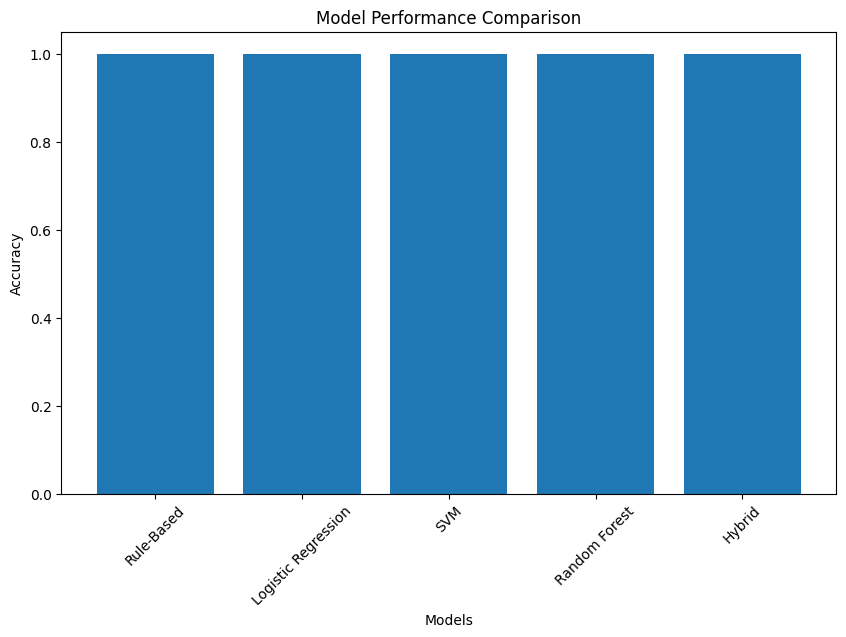

In [31]:
# Step 8: Compare All Models
results = {
    'Model': ['Rule-Based', 'Logistic Regression', 'SVM', 'Random Forest', 'Hybrid'],
    'Accuracy': [acc_rule, acc_lr, acc_svm, acc_rf, acc_hybrid],
    'Precision (macro)': [precision_score(y_test, y_pred_rule, average='macro', zero_division=0),
                         precision_score(y_test, y_pred_lr, average='macro', zero_division=0),
                         precision_score(y_test, y_pred_svm, average='macro', zero_division=0),
                         precision_score(y_test, y_pred_rf, average='macro', zero_division=0),
                         precision_score(y_test, y_pred_hybrid, average='macro', zero_division=0)],
    'Recall (macro)': [recall_score(y_test, y_pred_rule, average='macro', zero_division=0),
                       recall_score(y_test, y_pred_lr, average='macro', zero_division=0),
                       recall_score(y_test, y_pred_svm, average='macro', zero_division=0),
                       recall_score(y_test, y_pred_rf, average='macro', zero_division=0),
                       recall_score(y_test, y_pred_hybrid, average='macro', zero_division=0)],
    'F1-Score (macro)': [f1_score(y_test, y_pred_rule, average='macro', zero_division=0),
                         f1_score(y_test, y_pred_lr, average='macro', zero_division=0),
                         f1_score(y_test, y_pred_svm, average='macro', zero_division=0),
                         f1_score(y_test, y_pred_rf, average='macro', zero_division=0),
                         f1_score(y_test, y_pred_hybrid, average='macro', zero_division=0)]
}

results_df = pd.DataFrame(results)
print("Model Comparison:")
print(results_df)

# Visualize
plt.figure(figsize=(10, 6))
plt.bar(results_df['Model'], results_df['Accuracy'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45)
plt.show()

# Testing

Model Comparison:
                 Model  Accuracy  Precision (macro)  Recall (macro)  \
0           Rule-Based  0.531211           0.530824        0.529773   
1  Logistic Regression  0.635893           0.635790        0.635767   
2                  SVM  0.634734           0.634743        0.634776   
3        Random Forest  0.560878           0.611025        0.555366   
4               Hybrid  0.632726           0.632624        0.632605   

   F1-Score (macro)  
0          0.526435  
1          0.635775  
2          0.634715  
3          0.494711  
4          0.632612  


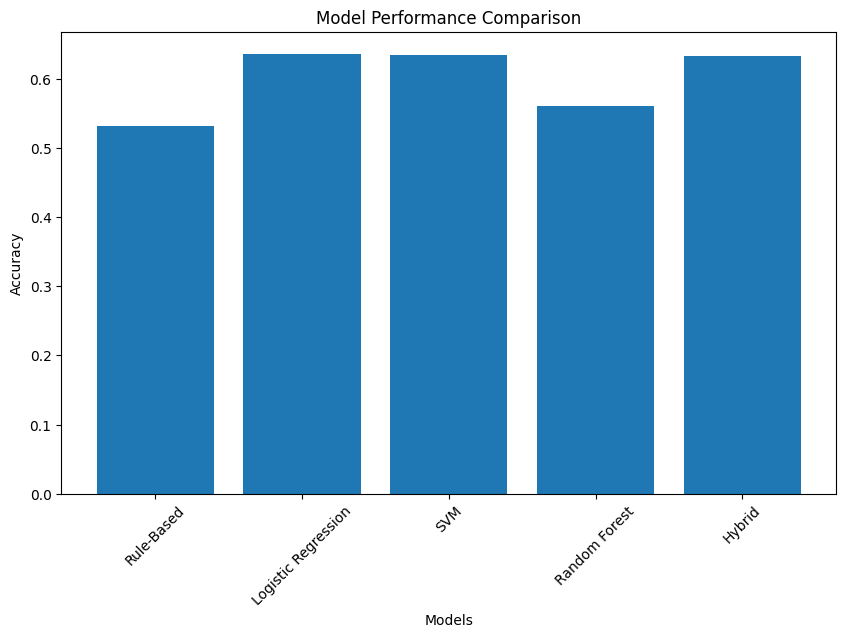

In [55]:
# Step 8: Compare All Models
results = {
    'Model': ['Rule-Based', 'Logistic Regression', 'SVM', 'Random Forest', 'Hybrid'],
    'Accuracy': [acc_rule, acc_lr, acc_svm, acc_rf, acc_hybrid],
    'Precision (macro)': [precision_score(y_test, y_pred_rule, average='macro', zero_division=0),
                         precision_score(y_test, y_pred_lr, average='macro', zero_division=0),
                         precision_score(y_test, y_pred_svm, average='macro', zero_division=0),
                         precision_score(y_test, y_pred_rf, average='macro', zero_division=0),
                         precision_score(y_test, y_pred_hybrid, average='macro', zero_division=0)],
    'Recall (macro)': [recall_score(y_test, y_pred_rule, average='macro', zero_division=0),
                       recall_score(y_test, y_pred_lr, average='macro', zero_division=0),
                       recall_score(y_test, y_pred_svm, average='macro', zero_division=0),
                       recall_score(y_test, y_pred_rf, average='macro', zero_division=0),
                       recall_score(y_test, y_pred_hybrid, average='macro', zero_division=0)],
    'F1-Score (macro)': [f1_score(y_test, y_pred_rule, average='macro', zero_division=0),
                         f1_score(y_test, y_pred_lr, average='macro', zero_division=0),
                         f1_score(y_test, y_pred_svm, average='macro', zero_division=0),
                         f1_score(y_test, y_pred_rf, average='macro', zero_division=0),
                         f1_score(y_test, y_pred_hybrid, average='macro', zero_division=0)]
}

results_df = pd.DataFrame(results)
print("Model Comparison:")
print(results_df)

# Visualize
plt.figure(figsize=(10, 6))
plt.bar(results_df['Model'], results_df['Accuracy'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45)
plt.show()

In [25]:
# Step 9: Input Different Reviews and Compare Results
def predict_sentiment(new_review):
    tfidf_vec = vectorizer.transform([new_review])
    rule_score = np.array([sia.polarity_scores(new_review)['compound']]).reshape(-1, 1)
    hybrid_vec = hstack((tfidf_vec, rule_score))

    rule_pred = rule_based_sentiment(new_review)
    lr_pred = lr_model.predict(tfidf_vec)[0]
    svm_pred = svm_model.predict(tfidf_vec)[0]
    rf_pred = rf_model.predict(tfidf_vec)[0]
    hybrid_pred = hybrid_model.predict(hybrid_vec)[0]

    # Decode labels - ensure inverse_transform is called with valid predicted labels
    # The models might predict 0 or 1, which correspond to 'Negative' and 'Positive'
    preds = {
        'Rule-Based': le.inverse_transform([rule_pred])[0],
        'Logistic Regression': le.inverse_transform([lr_pred])[0],
        'SVM': le.inverse_transform([svm_pred])[0],
        'Random Forest': le.inverse_transform([rf_pred])[0],
        'Hybrid': le.inverse_transform([hybrid_pred])[0]
    }
    return preds

# Test new reviews
new_reviews = [
    "The battery life is amazing, lasts all day!",
    "This product is terrible, broke after a week.",
    "It's okay, nothing special but works fine." # This review might be tricky for a binary model
]

for review in new_reviews:
    print(f"\nReview: {review}")
    print(predict_sentiment(review))


Review: The battery life is amazing, lasts all day!
{'Rule-Based': 'Positive', 'Logistic Regression': 'Positive', 'SVM': 'Positive', 'Random Forest': 'Positive', 'Hybrid': 'Positive'}

Review: This product is terrible, broke after a week.
{'Rule-Based': 'Negative', 'Logistic Regression': 'Negative', 'SVM': 'Negative', 'Random Forest': 'Negative', 'Hybrid': 'Negative'}

Review: It's okay, nothing special but works fine.
{'Rule-Based': 'Positive', 'Logistic Regression': 'Negative', 'SVM': 'Negative', 'Random Forest': 'Negative', 'Hybrid': 'Negative'}


# Testing

In [59]:
# Step 9: Input Different Reviews and Compare Results
def predict_sentiment(new_review):
    tfidf_vec = vectorizer.transform([new_review])
    rule_score = np.array([sia.polarity_scores(new_review)['compound']]).reshape(-1, 1)
    hybrid_vec = hstack((tfidf_vec, rule_score))

    rule_pred = rule_based_sentiment(new_review)
    lr_pred = lr_model.predict(tfidf_vec)[0]
    svm_pred = svm_model.predict(tfidf_vec)[0]
    rf_pred = rf_model.predict(tfidf_vec)[0]
    hybrid_pred = hybrid_model.predict(hybrid_vec)[0]

    # Decode labels - ensure inverse_transform is called with valid predicted labels
    # The models might predict 0 or 1, which correspond to 'Negative' and 'Positive'
    preds = {
        'Rule-Based': le.inverse_transform([rule_pred])[0],
        'Logistic Regression': le.inverse_transform([lr_pred])[0],
        'SVM': le.inverse_transform([svm_pred])[0],
        'Random Forest': le.inverse_transform([rf_pred])[0],
        'Hybrid': le.inverse_transform([hybrid_pred])[0]
    }
    return preds

# Test new reviews
new_reviews = [
    "The battery life is amazing, lasts all day!",
    "This product is terrible, broke after a week.",
    "It's okay, nothing special but works fine." ,
    "False statements or representation"
]

for review in new_reviews:
    print(f"\nReview: {review}")
    print(predict_sentiment(review))


Review: The battery life is amazing, lasts all day!
{'Rule-Based': 'pos', 'Logistic Regression': 'pos', 'SVM': 'pos', 'Random Forest': 'pos', 'Hybrid': 'pos'}

Review: This product is terrible, broke after a week.
{'Rule-Based': 'neg', 'Logistic Regression': 'neg', 'SVM': 'neg', 'Random Forest': 'neg', 'Hybrid': 'neg'}

Review: It's okay, nothing special but works fine.
{'Rule-Based': 'pos', 'Logistic Regression': 'pos', 'SVM': 'pos', 'Random Forest': 'pos', 'Hybrid': 'pos'}

Review: False statements or representation
{'Rule-Based': 'pos', 'Logistic Regression': 'neg', 'SVM': 'neg', 'Random Forest': 'pos', 'Hybrid': 'neg'}
